<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the preprocessed data
fr_tx, fr_idx = read_preprocessed('fr')

# Take a look at the size of the precleaned data
sys.getsizeof(fr_tx)

3849360

In [6]:
# Take a look at the preprocessed data
fr_tx[0][:6]

['bourse', 'york', 'terminer', 'hausse', 'mercredi', 'espoir']

In [7]:
# Take a look at the dataframe containing the according index
fr_idx.tail(3)

,fr_idx
481159,2436480
481160,2436481
481161,2436482


In [8]:
# Retrieve the location of the article in the preprocessed data using the according article id
article_ids = [2436481, 2436482]
location = fr_idx[fr_idx.fr_idx.isin(article_ids)].index.tolist() #481160

# Access the preprocessed text from the articles with the article ids in [2436481, 2436482]
#list(fr_tx[i] for i in location)

# Look at the according location of the articles with the article ids in [2436481, 2436482]
location

[481160, 481161]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [9]:
# Create Dictionary
dictionary = corpora.Dictionary(fr_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(fr_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2765

In [10]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in fr_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 4), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 4), (22, 2), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 4), (83, 2), (84, 1), (85, 1)]]


In [11]:
# Remove unnecessary variables to save RAM
del fr_tx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- In order to observe the word that corresponds to a given id, pass the id as a key to the dictionary.

In [12]:
# Get the phrase corresponding to id 0
dictionary[0]

'accord'

In [13]:
# Get a human readable format of the corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 1),
  ('action', 1),
  ('aide', 2),
  ('américain', 3),
  ('an', 1),
  ('augmenter', 1),
  ('avancer', 1),
  ('baisse', 1),
  ('bourse', 4),
  ('camion', 1),
  ('chambre', 1),
  ('chef', 1),
  ('cheffe', 1),
  ('compromis', 1),
  ('coup', 1),
  ('cours', 1),
  ('céder', 1),
  ('dette', 1),
  ('devoir', 1),
  ('discret', 1),
  ('discuter', 1),
  ('dollar', 4),
  ('donner', 2),
  ('donnée', 1),
  ('débat', 1),
  ('démocrate', 1),
  ('espoir', 2),
  ('expliquer', 1),
  ('fabricant', 1),
  ('gagner', 1),
  ('grand', 2),
  ('groupe', 1),
  ('hausse', 1),
  ('introduction', 2),
  ('laboratoire', 1),
  ('lire', 1),
  ('léger', 1),
  ('marché', 1),
  ('mardi', 3),
  ('marquer', 1),
  ('mener', 1),
  ('mercredi', 3),
  ('milliard', 1),
  ('mois', 1),
  ('mot', 1),
  ('new', 1),
  ('nom', 1),
  ('nouveau', 1),
  ('page', 1),
  ('perte', 1),
  ('plan', 1),
  ('point', 3),
  ('position', 1),
  ('prendre', 1),
  ('prix', 2),
  ('prochain', 1),
  ('progresser', 2),
  ('présenter', 1),
 

In [14]:
# Search for a specific word (here: coronavirus & covid) in the preprocessed dictionary
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break   

At pos. 674 we find the word coronavirus
At pos. 91 we find the word covid


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonably and in feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics)
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)

In [15]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 25,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  24.202788583437602 minutes


In [16]:
# Save the model to harddisk
lda_model.save("LDA/fr_lda_model_"+str(lda_model.num_topics)+"_topics")

In [17]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of distingushied topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/fr_lda_model_25_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(23,
  '0.021*"école" + 0.014*"jeune" + 0.012*"formation" + 0.012*"élève" + '
  '0.010*"professionnel" + 0.010*"association" + 0.010*"personne" + '
  '0.009*"enfant" + 0.009*"étudiant" + 0.009*"cours"'),
 (20,
  '0.020*"eau" + 0.015*"sud" + 0.011*"kilomètre" + 0.010*"nord" + '
  '0.010*"mètre" + 0.010*"île" + 0.009*"région" + 0.009*"terre" + 0.008*"mer" '
  '+ 0.008*"année"'),
 (13,
  '0.031*"entreprise" + 0.017*"client" + 0.014*"société" + 0.013*"marché" + '
  '0.011*"vente" + 0.010*"prix" + 0.009*"groupe" + 0.009*"commerce" + '
  '0.009*"suisse" + 0.009*"produit"'),
 (18,
  '0.015*"pays" + 0.010*"armée" + 0.010*"militaire" + 0.009*"force" + '
  '0.009*"président" + 0.008*"gouvernement" + 0.008*"guerre" + '
  '0.007*"manifestation" + 0.007*"russe" + 0.007*"personne"'),
 (10,
  '0.025*"fr" + 0.021*"produit" + 0.017*"animal" + 0.015*"petit" + '
  '0.015*"noël" + 0.013*"vin" + 0.012*"restaurant" + 0.009*"eau" + 0.009*"bon" '
  '+ 0.008*"alimentaire"'),
 (17,
  '0.016*"match" + 0.014*"éq

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/fr_lda_model_25_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data
fr_tx, fr_idx = read_preprocessed('fr')

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in fr_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 25 topics: -7.113988746441761


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = fr_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 25 topics: 0.5695924859291435


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We do so by means of the pyLDAvis package’s interactive chart which is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.018702  0.102126       1        1  12.095105
17    -0.017620  0.063204       2        1   8.242632
0      0.001659  0.164804       3        1   5.978636
18    -0.194477 -0.044488       4        1   4.976200
24     0.082716 -0.181687       5        1   4.745767
16    -0.058971 -0.048733       6        1   4.592859
5      0.123086 -0.139271       7        1   4.402634
2     -0.135221 -0.064769       8        1   4.155314
14     0.066757  0.019694       9        1   4.092115
3     -0.034965 -0.146417      10        1   4.066140
9     -0.088940 -0.075252      11        1   3.622547
7      0.073198 -0.108176      12        1   3.580761
23     0.109100  0.030856      13        1   3.342256
13     0.169441  0.020951      14        1   3.269106
8     -0.166420  0.141326      15        1   3.204222
1     -0.160361 -0.095900      16        1   3.196003
15     0.116219 -0.021040      17        1   3.150947
20    -0.060340  0.134086      18        1   2.966096
4     -0.151602 -0.117916      19        1   2.923785
11     0.111516 -0.087964      20        1   2.806140
21    -0.100690  0.173995      21        1   2.458075
6     -0.005016  0.013222      22        1   2.450338
22     0.172964  0.008051      23        1   2.027060
12    -0.017294  0.076335      24        1   1.836795
10     0.146561  0.182961      25        1   1.818464, topic_info=          Term           Freq          Total Category  logprob  loglift
169     suisse  448221.000000  448221.000000  Default  30.0000  30.0000
4           an  494152.000000  494152.000000  Default  29.0000  29.0000
443      femme  132706.000000  132706.000000  Default  28.0000  28.0000
348  président  225883.000000  225883.000000  Default  27.0000  27.0000
195    million  198224.000000  198224.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
162      rouge    7216.560522   33436.279335  Topic25  -5.1665   2.4739
572     servir    6956.383902   35734.621982  Topic25  -5.2032   2.3707
30       grand    7490.003266  287529.663989  Topic25  -5.1293   0.3594
316     mettre    6860.354579  225055.834757  Topic25  -5.2171   0.5166
537      faire    6713.156510  295453.397903  Topic25  -5.2388   0.2227

[1272 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1830      4  0.018688   abus
1830      5  0.059604   abus
1830      8  0.825378   abus
1830     10  0.000907   abus
1830     16  0.013971   abus
...     ...       ...    ...
590      14  0.018063  œuvre
590      17  0.001887  œuvre
590      19  0.013887  œuvre
590      20  0.007371  œuvre
590      23  0.008478  œuvre

[9952 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 1, 19, 25, 17, 6, 3, 15, 4, 10, 8, 24, 14, 9, 2, 16, 21, 5, 12, 22, 7, 23, 13, 11])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data
fr_tx = read_preprocessed('fr')[0]

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(fr_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(fr_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2765

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in fr_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 4), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 4), (22, 2), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 4), (83, 2), (84, 1), (85, 1)]]


In [8]:
def compare_lda_models(dictionary, corpus, texts, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/fr_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [9]:
## 1. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 10, max_k = 50, step = 5)

Processing time to build the LDA multicore model with 10 topics: 19.333409031232197 minutes
Coherence Score of the LDA multicore model with 10 topics: 0.5187397044577031
Processing time to build the LDA multicore model with 15 topics: 19.016768836975096 minutes
Coherence Score of the LDA multicore model with 15 topics: 0.5507026952942549
Processing time to build the LDA multicore model with 20 topics: 18.99693559408188 minutes
Coherence Score of the LDA multicore model with 20 topics: 0.5781026462430874
Processing time to build the LDA multicore model with 25 topics: 19.223962012926737 minutes
Coherence Score of the LDA multicore model with 25 topics: 0.5673412493722695
Processing time to build the LDA multicore model with 30 topics: 19.794656093915304 minutes
Coherence Score of the LDA multicore model with 30 topics: 0.5712374534451014
Processing time to build the LDA multicore model with 35 topics: 26.914987846215567 minutes
Coherence Score of the LDA multicore model with 35 topics: 

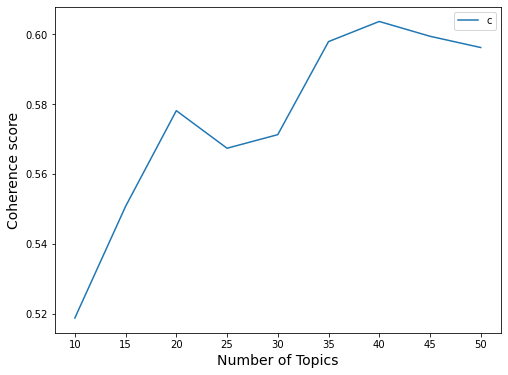

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

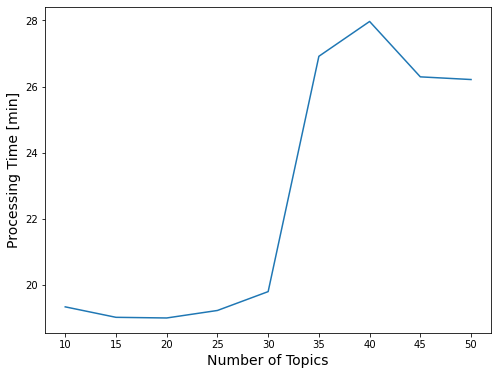

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.5187397044577031,
 0.5507026952942549,
 0.5781026462430874,
 0.5673412493722695,
 0.5712374534451014,
 0.5978725245941722,
 0.6036432857296602,
 0.5994084593502896,
 0.5961821793508404]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[19.333409031232197,
 19.016768836975096,
 18.99693559408188,
 19.223962012926737,
 19.794656093915304,
 26.914987846215567,
 27.96877376238505,
 26.292873700459797,
 26.211843474706015]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [9]:
## 2. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 1, max_k = 5, step = 4)

Processing time to build the LDA multicore model with 1 topics: 3.631579383214315 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.25978482561337474
Processing time to build the LDA multicore model with 5 topics: 17.768262239297233 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.4347043560570928


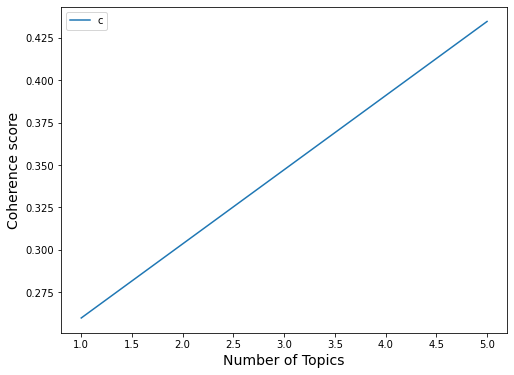

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

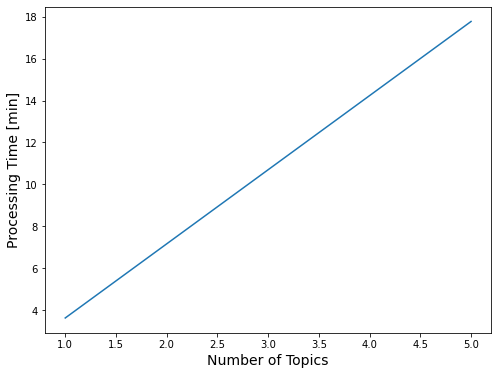

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.25978482561337474, 0.4347043560570928]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[3.631579383214315, 17.768262239297233]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[1, 5]

In [9]:
## 3. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 21, max_k = 24, step = 1)

Processing time to build the LDA multicore model with 21 topics: 20.287527004877727 minutes
Coherence Score of the LDA multicore model with 21 topics: 0.5543243429352402
Processing time to build the LDA multicore model with 22 topics: 18.886265305678048 minutes
Coherence Score of the LDA multicore model with 22 topics: 0.5676188714616152
Processing time to build the LDA multicore model with 23 topics: 18.95007759332657 minutes
Coherence Score of the LDA multicore model with 23 topics: 0.5699735938746425
Processing time to build the LDA multicore model with 24 topics: 19.54176633755366 minutes
Coherence Score of the LDA multicore model with 24 topics: 0.5753103969092054


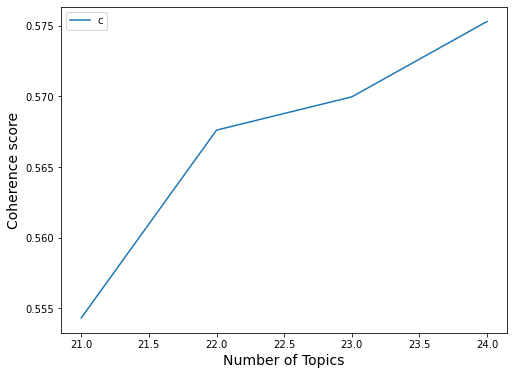

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

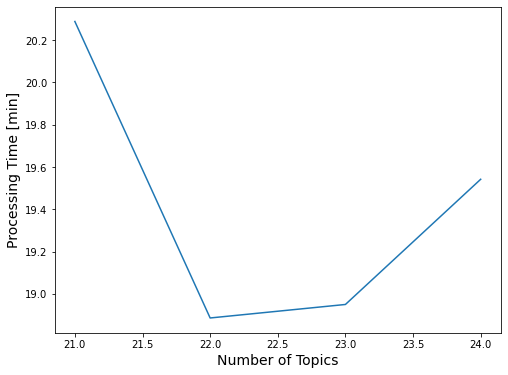

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.5543243429352402,
 0.5676188714616152,
 0.5699735938746425,
 0.5753103969092054]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[20.287527004877727, 18.886265305678048, 18.95007759332657, 19.54176633755366]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[21, 22, 23, 24]

In [9]:
## 4. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 26, max_k = 29, step = 1)

Processing time to build the LDA multicore model with 26 topics: 19.852548627058663 minutes
Coherence Score of the LDA multicore model with 26 topics: 0.565529354600614
Processing time to build the LDA multicore model with 27 topics: 20.20759854714076 minutes
Coherence Score of the LDA multicore model with 27 topics: 0.5858317859601856
Processing time to build the LDA multicore model with 28 topics: 19.481585868199666 minutes
Coherence Score of the LDA multicore model with 28 topics: 0.5718780350061142
Processing time to build the LDA multicore model with 29 topics: 19.624996189276377 minutes
Coherence Score of the LDA multicore model with 29 topics: 0.5730502516065149


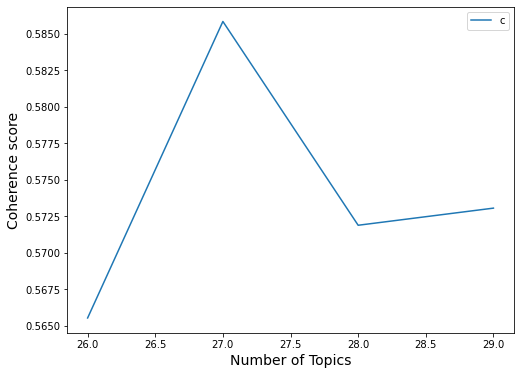

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

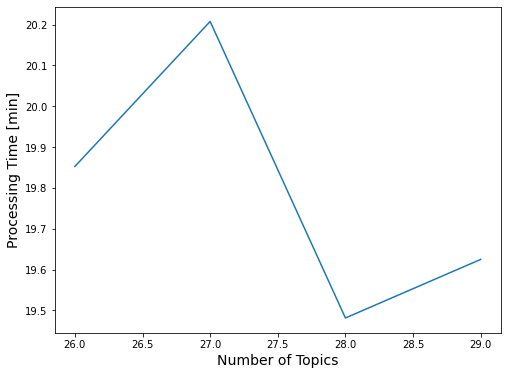

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.565529354600614, 0.5858317859601856, 0.5718780350061142, 0.5730502516065149]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[19.852548627058663, 20.20759854714076, 19.481585868199666, 19.624996189276377]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[26, 27, 28, 29]

In [15]:
## 5. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, fr_tx, min_k = 31, max_k = 34, step = 1)

Processing time to build the LDA multicore model with 31 topics: 19.35622545480728 minutes
Coherence Score of the LDA multicore model with 31 topics: 0.5893654902396178
Processing time to build the LDA multicore model with 32 topics: 20.357680849234264 minutes
Coherence Score of the LDA multicore model with 32 topics: 0.5840443586657601
Processing time to build the LDA multicore model with 33 topics: 22.2405899922053 minutes
Coherence Score of the LDA multicore model with 33 topics: 0.5804824705156472
Processing time to build the LDA multicore model with 34 topics: 26.52350676457087 minutes
Coherence Score of the LDA multicore model with 34 topics: 0.5952131392291374


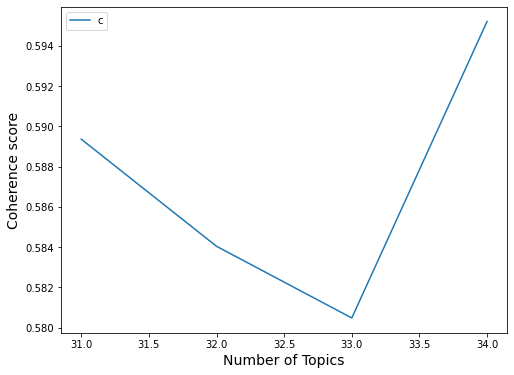

In [16]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

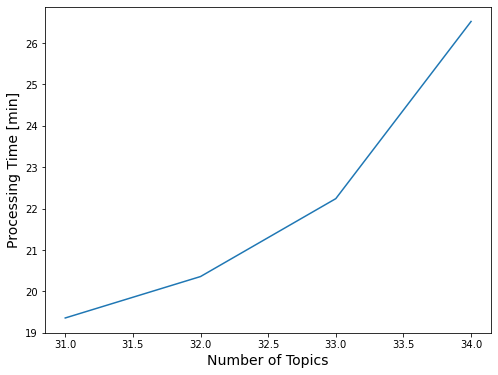

In [17]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [18]:
# Take a look at the resulting coherence scores
coherence_values

[0.5893654902396178,
 0.5840443586657601,
 0.5804824705156472,
 0.5952131392291374]

In [19]:
# Take a look at the required processing times (in minutes)
processing_times

[19.35622545480728, 20.357680849234264, 22.2405899922053, 26.52350676457087]

In [20]:
# Take a look at the grid of the number of topics
n_topics

[31, 32, 33, 34]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
## Storage of the results for LdaMulticore model with passes = 12
# 1. Run
coherence_values = [0.5187397044577031, 0.5507026952942549, 0.5781026462430874, 0.5673412493722695, 0.5712374534451014, 
                    0.5978725245941722, 0.6036432857296602, 0.5994084593502896, 0.5961821793508404]
processing_times = [19.333409031232197, 19.016768836975096, 18.99693559408188, 19.223962012926737, 19.794656093915304,
                    26.914987846215567, 27.96877376238505, 26.292873700459797, 26.211843474706015]
n_topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# 2. Run
coherence_values = [0.25978482561337474, 0.4347043560570928]
processing_times = [3.631579383214315, 17.768262239297233]
n_topics = [1, 5]

# 3. Run
coherence_values = [0.5543243429352402, 0.5676188714616152, 0.5699735938746425, 0.5753103969092054]
processing_times = [20.287527004877727, 18.886265305678048, 18.95007759332657, 19.54176633755366]
n_topics = [21, 22, 23, 24]

# 4. Run
coherence_values = [0.565529354600614, 0.5858317859601856, 0.5718780350061142, 0.5730502516065149]
processing_times = [19.852548627058663, 20.20759854714076, 19.481585868199666, 19.624996189276377]
n_topics = [26, 27, 28, 29]

# 5. Run
coherence_values = [0.5893654902396178, 0.5840443586657601, 0.5804824705156472, 0.5952131392291374]
processing_times = [19.35622545480728, 20.357680849234264, 22.2405899922053, 26.52350676457087]
n_topics = [31, 32, 33, 34]


# Joint
coherence_values = [0.25978482561337474, 0.4347043560570928, 0.5187397044577031, 0.5507026952942549, 0.5781026462430874, 
                    0.5543243429352402,  0.5676188714616152, 0.5699735938746425, 0.5753103969092054, 0.5673412493722695, 
                    0.565529354600614,   0.5858317859601856, 0.5718780350061142, 0.5730502516065149, 0.5712374534451014, 
                    0.5893654902396178,  0.5840443586657601, 0.5804824705156472, 0.5952131392291374, 0.5978725245941722, 
                    0.6036432857296602,  0.5994084593502896, 0.5961821793508404]
processing_times = [3.631579383214315,  17.768262239297233, 19.333409031232197, 19.016768836975096, 18.99693559408188, 
                    20.287527004877727, 18.886265305678048, 18.95007759332657,  19.54176633755366,  19.223962012926737, 
                    19.852548627058663, 20.20759854714076,  19.481585868199666, 19.624996189276377, 19.794656093915304,
                    19.35622545480728,  20.357680849234264, 22.2405899922053,   26.52350676457087,  26.914987846215567, 
                    27.96877376238505,  26.292873700459797, 26.211843474706015]
n_topics = [1,  5,  10, 15, 20, 
            21, 22, 23, 24, 25, 
            26, 27, 28, 29, 30, 
            31, 32, 33, 34, 35, 
            40, 45, 50]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

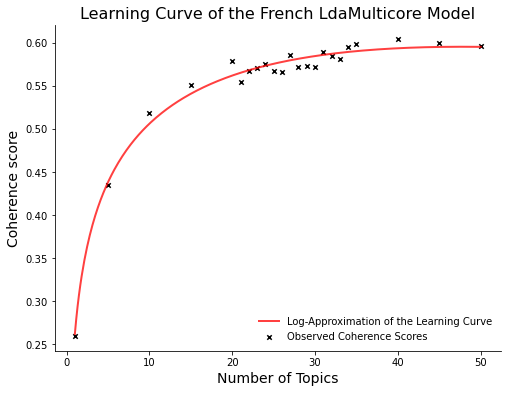

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the French LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

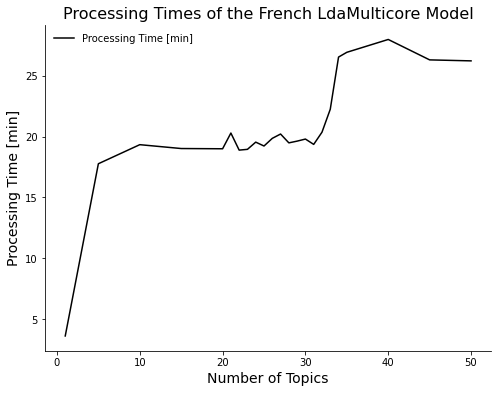

In [8]:
# Show the evolvement of the processing time 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the French LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [5]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.5187397044577031,  0.5507026952942549, 0.5781026462430874, 
                    0.5543243429352402,  0.5676188714616152, 0.5699735938746425, 0.5753103969092054, 0.5673412493722695, 
                    0.565529354600614,   0.5858317859601856, 0.5718780350061142, 0.5730502516065149, 0.5712374534451014, 
                    0.5893654902396178,  0.5840443586657601, 0.5804824705156472, 0.5952131392291374, 0.5978725245941722, 
                    0.6036432857296602,  0.5994084593502896, 0.5961821793508404]
processing_times = [19.333409031232197, 19.016768836975096, 18.99693559408188, 
                    20.287527004877727, 18.886265305678048, 18.95007759332657,  19.54176633755366,  19.223962012926737, 
                    19.852548627058663, 20.20759854714076,  19.481585868199666, 19.624996189276377, 19.794656093915304,
                    19.35622545480728,  20.357680849234264, 22.2405899922053,   26.52350676457087,  26.914987846215567, 
                    27.96877376238505,  26.292873700459797, 26.211843474706015]
n_topics = [10, 15, 20, 
            21, 22, 23, 24, 25, 
            26, 27, 28, 29, 30, 
            31, 32, 33, 34, 35, 
            40, 45, 50]

In [6]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [7]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/fr_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [8]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [9]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

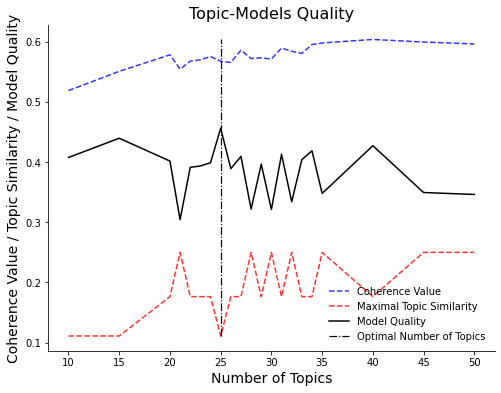

In [14]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Score')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximum Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(max_topic_similarities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Score / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [15]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 25


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 25 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the French articles, this strategy leads us to an optimal choice of $K^* = 27$ for the general LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 27  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/fr_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.033*"voiture" + 0.031*"heure" + 0.028*"véhicule" + 0.025*"route" + '
  '0.023*"transport" + 0.020*"train" + 0.019*"kilomètre" + 0.017*"électrique" '
  '+ 0.014*"trafic" + 0.013*"ligne"'),
 (1,
  '0.051*"américain" + 0.040*"trump" + 0.035*"unis" + 0.029*"président" + '
  '0.028*"donald" + 0.026*"etat" + 0.019*"état" + 0.019*"biden" + 0.016*"joe" '
  '+ 0.015*"chine"'),
 (2,
  '0.033*"parti" + 0.022*"élection" + 0.020*"politique" + 0.016*"candidat" + '
  '0.016*"président" + 0.015*"vote" + 0.013*"conseil" + 0.012*"plr" + '
  '0.012*"gauche" + 0.011*"udc"'),
 (3,
  '0.033*"eau" + 0.020*"animal" + 0.011*"petit" + 0.011*"terre" + '
  '0.010*"espèce" + 0.010*"lac" + 0.009*"forêt" + 0.009*"arbre" + '
  '0.009*"nature" + 0.008*"année"'),
 (4,
  '0.053*"européen" + 0.037*"accord" + 0.022*"britannique" + 0.020*"royaume" + '
  '0.020*"ue" + 0.019*"uni" + 0.017*"pays" + 0.017*"union" + 0.016*"ministre" '
  '+ 0.013*"allemagne"'),
 (5,
  '0.018*"an" + 0.017*"tribunal" + 0.017*"justice" + 

In [6]:
# Read in the preprocessed data
fr_tx = read_preprocessed('fr')[0]

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in fr_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
25     0.099280  0.024388       1        1  10.256823
8      0.045758  0.155257       2        1   7.124549
17     0.018619  0.128062       3        1   5.103862
24     0.005094 -0.223878       4        1   4.820867
18    -0.185131 -0.007252       5        1   4.653559
16    -0.047663 -0.013894       6        1   4.355111
9     -0.041941 -0.094864       7        1   4.286585
5     -0.100709 -0.022255       8        1   4.029164
19     0.067554  0.109046       9        1   3.989445
26     0.015865  0.164078      10        1   3.743944
2     -0.116356 -0.026506      11        1   3.734064
14     0.075209 -0.033957      12        1   3.699499
22     0.089835 -0.154804      13        1   3.686154
20    -0.070110  0.152094      14        1   3.650011
11     0.069131 -0.101461      15        1   3.448902
21     0.184956 -0.012376      16        1   3.335957
23     0.112212  0.011518      17        1   3.109695
7      0.033729 -0.122618      18        1   3.089309
1     -0.185592 -0.023166      19        1   2.994138
15     0.130914 -0.082712      20        1   2.729186
3      0.139223  0.101356      21        1   2.463577
4     -0.167490 -0.070291      22        1   2.387371
6      0.042686 -0.061714      23        1   2.379580
13    -0.000671 -0.148930      24        1   2.115720
0      0.054379  0.133946      25        1   1.674172
12     0.016973  0.152781      26        1   1.644074
10    -0.285754  0.068154      27        1   1.494685, topic_info=          Term           Freq          Total Category  logprob  loglift
169     suisse  448866.000000  448866.000000  Default  30.0000  30.0000
195    million  186328.000000  186328.000000  Default  29.0000  29.0000
1077    canton  149303.000000  149303.000000  Default  28.0000  28.0000
190      franc  168143.000000  168143.000000  Default  27.0000  27.0000
295    fédéral  169475.000000  169475.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
318   national    8341.098176  112026.954111  Topic27  -4.8256   1.6057
532   européen    7595.855861  106584.663274  Topic27  -4.9192   1.5619
1110      jean    6667.226668   65518.623989  Topic27  -5.0496   1.9181
30       grand    7503.103682  287342.307939  Topic27  -4.9315   0.5579
1135     jeudi    6816.001742   90768.489252  Topic27  -5.0276   1.6142

[1349 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1587      1  0.047142  abattre
1587      2  0.024990  abattre
1587      3  0.015012  abattre
1587      5  0.136757  abattre
1587      8  0.022884  abattre
...     ...       ...      ...
590      16  0.002094    œuvre
590      17  0.000414    œuvre
590      21  0.000390    œuvre
590      22  0.015414    œuvre
590      24  0.004115    œuvre

[11092 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 9, 18, 25, 19, 17, 10, 6, 20, 27, 3, 15, 23, 21, 12, 22, 24, 8, 2, 16, 4, 5, 7, 14, 1, 13, 11])

In [9]:
# Delete unnecessary variables
del fr_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Read in the preprocessed fulltext data
fr_tx_fulltext, fr_idx = read_preprocessed_fulltext('fr')

In [11]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore return a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [12]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 5.091177467505137 minutes


In [13]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 5.061749025185903 minutes


In [14]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = fr_idx.fr_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Topic_Assignment/fr_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 27  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/fr_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Topic_Assignment/fr_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed fulltext data
fr_tx_fulltext, fr_idx = read_preprocessed_fulltext('fr')

In [ ]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [ ]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(0,
 [('voiture', 0.03270419),
  ('heure', 0.031087967),
  ('véhicule', 0.02781903),
  ('route', 0.025110116),
  ('transport', 0.023122428),
  ('train', 0.019988054),
  ('kilomètre', 0.019271765),
  ('électrique', 0.0173103),
  ('trafic', 0.013742635),
  ('ligne', 0.012786406),
  ('gare', 0.012483154),
  ('cff', 0.0116091315),
  ('conducteur', 0.011417138),
  ('vélo', 0.010421794),
  ('bus', 0.009973078),
  ('circulation', 0.009547501),
  ('voie', 0.009109857),
  ('accident', 0.008454166),
  ('vitesse', 0.008080222),
  ('mobilité', 0.007686315)])


[' Les CFF entreprennent plusieurs chantiers de modernisation des installations ferroviaires qui entraîneront des modifications d’horaire durant les trois prochains week ends d’octobre. Le week end du 23 au 25 octobre, le tronçon Vevey Clarens sera mis en simple voie, en raison de travaux à la gare de La Tour de Peilz. Des Regio Express seront supprimés entre Vevey et Saint Maurice (S2) et Villeneuve (S3). Ils seront remplacés par des bus. Les trains IR et EC circulent normalement. Sur la ligne Monthey Saint Gingolph, deux chantiers entraîneront la fermeture de la ligne et le remplacement des trains par des bus durant le week end des 24 et 25 octobre: la réfection du passage à niveau du Fenalet, entre Le Bouveret et Saint Gingolph, ainsi que le remplacement du pont du Fossau, à Vouvry. Les travaux de modernisation de la gare de Bex nécessiteront du 16 octobre au 10 novembre le ralentissement des trains à 50 km/h lors de leur passage en gare, en direction du Valais. Aucune suppression d

In [ ]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10)

(1,
 [('américain', 0.05092345),
  ('trump', 0.040262874),
  ('unis', 0.035211496),
  ('président', 0.02893586),
  ('donald', 0.027754644),
  ('etat', 0.025565747),
  ('état', 0.018881544),
  ('biden', 0.018784333),
  ('joe', 0.01614882),
  ('chine', 0.015068357),
  ('chinois', 0.013784555),
  ('démocrate', 0.01247547),
  ('républicain', 0.009918989),
  ('washington', 0.009198064),
  ('maison', 0.008241915),
  ('blanche', 0.0076065483),
  ('pays', 0.0069741183),
  ('york', 0.0058362074),
  ('pékin', 0.005819823),
  ('congrès', 0.004908774)])


[" Donald Trump a déclaré qu'il avait hâte de tenir un nouveau sommet avec le dirigeant nord coréen Kim Jong Un, qui s'était dit prêt à rencontrer une nouvelle fois le président américain à tout moment. Mais le leader nord coréen a averti dans son discours que Pyongyang pourrait changer d'attitude si Washington maintenait, malgré le rapprochement diplomatique opéré depuis juin, ses sanctions économiques contre la Corée du Nord. Les Etats Unis exigent une dénucléarisation totalement vérifiée du Nord avant toute levée des sanctions, alors que Pyongyang accuse Washington d'exiger son désarmement unilatéral sans faire de concessions. (afp)",
 " Les démocrates ont remporté mardi une victoire face à Donald Trump avec le rejet, à la chambre basse du Congrès, de l' urgence nationale décrétée par le président américain pour pouvoir construire son mur anti immigration clandestine. Le Sénat, contrôlé par les républicains, donnera t il l'estocade? Des sénateurs républicains ont exprimé leur malais

In [ ]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(2,
 [('parti', 0.03347505),
  ('élection', 0.021830799),
  ('politique', 0.020498982),
  ('candidat', 0.016161852),
  ('président', 0.015705127),
  ('vote', 0.014556184),
  ('conseil', 0.012806597),
  ('plr', 0.012053159),
  ('gauche', 0.011710402),
  ('udc', 0.010877485),
  ('droite', 0.010134552),
  ('campagne', 0.009925116),
  ('élu', 0.009498731),
  ('an', 0.009489468),
  ('voix', 0.0091896895),
  ('pdc', 0.009064413),
  ('siège', 0.008953998),
  ('national', 0.0087633785),
  ('socialiste', 0.008227357),
  ('résultat', 0.007745187)])


[' Issus de huit partis, cinq femmes et huit hommes ont présenté leur candidature pour un mandat au sein du Gouvernement jurassien. Le scrutin aura lieu le 18 octobre. ATS/NXPIl n’y a pas eu de candidature surprise de dernière minute lundi lors de l’échéance du dépôt des listes pour l’élection au Gouvernement jurassien. Cinq femmes et huit hommes sont en course pour l’élection au Gouvernement jurassien cet automne. Les cinq ministres sortants briguent un nouveau mandat. Le principal enjeu du scrutin du 18 octobre est de savoir si le PDC parviendra à retrouver son second siège perdu lors de l’élection complémentaire du 1er mars. Il n’y a pas eu de candidature surprise de dernière minute lors de l’échéance du dépôt des listes lundi à midi. Les treize candidats sont issus de huit partis. Une nouvelle formation se lance dans la course au gouvernement, les Vert’libéraux. Il y a cinq ans, l’on comptait 18 candidats. Candidats lancés dans la batailleLe PDC lance deux candidats dans la bataill

In [ ]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(3,
 [('eau', 0.033277676),
  ('animal', 0.0202213),
  ('petit', 0.011356821),
  ('terre', 0.010835746),
  ('espèce', 0.010166248),
  ('lac', 0.009893114),
  ('forêt', 0.009220946),
  ('arbre', 0.008914887),
  ('nature', 0.008607992),
  ('année', 0.008056257),
  ('grand', 0.0074599967),
  ('chien', 0.0073977346),
  ('bois', 0.0070474893),
  ('mètre', 0.0063034147),
  ('déchet', 0.005929375),
  ('tonne', 0.0056469315),
  ('zone', 0.0055209864),
  ('plastique', 0.0054539507),
  ('sol', 0.0052381144),
  ('oiseau', 0.0052332105)])


[' Temps de préparation 1 heure (temps de cuisson inclus)Ingrédients 150 g (¾ de tasse) de quinoa noir et de quinoa blanc 8 9 pommes de terre moyennes à chair farineuse 1 gros oignon 2 c. s. d’huile végétale neutre ½ botte d’herbes fraîches mélangées (thym, persil, romarin, sauge) 3 4 c. s. de fécule de maïs 1 c. s. rase de sel 1 pincée de poivre noir moulu 1 c. s. de curry de Madras en poudre 1 c. s. rase de bouillon de légumes en poudreDans une casserole, porter 600 ml (2 ½ tasses) d’eau à ébullition, puis éteindre le feu. Ajouter les deux sortes de quinoa, bien mélanger et laisser tremper à couvert pendant 20 minutes avant de retirer l’excédent d’eau. Pendant ce temps, éplucher les pommes de terre, les couper en dés de 1 cm et les faire bouillir dans de l’eau non salée jusqu’à ce qu’elles soient tendres. Egoutter et laisser refroidir. Peler l’oignon, le détailler et le faire revenir dans l’huile avant de le verser dans un gros bol. Y ajouter le quinoa cuit ainsi que les dés de pomme

In [ ]:
# Further highly ranked articles of topic 3
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1000, show_n_last_elements = 5)

[' Le taux de recyclage devra passer de 50 à 60 d’ici à 2025. Un objectif à portée de main. Infographie: LargeNetworkToujours plus de recyclageEn milliers de tonnesDéchets recyclés*Bouteilles en plastiqueFlacons de lessive, bouteilles de lait, shampooings, récipients d’huile ou de vinaigre: autant de déchets qui ne sont pas recyclables avec le PET. Il est impératif de les déposer dans les collectes installées dans la plupart des supermarchés. Déchets recyclablesPET, verre, papier, aluminium, etc. Déchets vertsÉpluchures, restes de repas, feuilles mortes, branches, etc. Déchets incinérablesNon recyclables (emballages, vaisselle, couches culottes, etc. )Déchets encombrantsMeubles, matelas, etc. Au fil de l’eau40 La proportion de déchets incinérables amenés par barge à l’usine des Cheneviers. Le transport fluvial permet d’éviter les trajets de 13 000 camions par année. Espaces de récupérationTrois sites permettent aux particuliers de déposer gratuitement différents types de déchets. Le sa

In [ ]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(4,
 [('européen', 0.052963883),
  ('accord', 0.03720645),
  ('britannique', 0.022453135),
  ('royaume', 0.02005511),
  ('ue', 0.020008605),
  ('uni', 0.01923796),
  ('pays', 0.016931472),
  ('union', 0.016858894),
  ('ministre', 0.016032621),
  ('allemagne', 0.012937629),
  ('allemand', 0.012796602),
  ('europe', 0.011079438),
  ('brexit', 0.010341197),
  ('gouvernement', 0.009190855),
  ('londres', 0.008868789),
  ('johnson', 0.008697494),
  ('négociation', 0.008196292),
  ('boris', 0.008060851),
  ('commission', 0.006082835),
  ('fin', 0.005946043)])


[' Angela Merkel croit encore en un accord. Selon la chancelière allemande Angela Merkel, les négociations sur la sortie du Royaume Uni de l’Union européenne ne sont pas totalement au point mort. ATS/NXPAngela Merkel croit encore en un accord. Angela Merkel a estimé mercredi qu’il y avait encore une chance de parvenir à un accord sur le Brexit entre la Grande Bretagne et l’Union européenne. Un éventuel accord doit préserver l’intégrité du marché intérieur de l’UE, a mis en garde devant la chambre basse du parlement la chancelière allemande, dont le pays préside jusqu’à la fin de l’année le Conseil de l’UE. Il y a encore une chance de parvenir à un accord. Je ne sais pas si nous réussirons d’ici demain (jeudi), je ne peux pas le promettre, mais nous continuons à y travailler, a assuré la dirigeante allemande. Nous continuons à travailler, mais nous sommes également prêts à être confrontés à des conditions que nous ne pourrons pas accepter, a également prévenu Angela Merkel. Nous devons 

In [ ]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 8)

(5,
 [('an', 0.017927723),
  ('tribunal', 0.016954148),
  ('justice', 0.016534254),
  ('enquête', 0.0144456895),
  ('avocat', 0.013411538),
  ('affaire', 0.012876628),
  ('prison', 0.010072039),
  ('cour', 0.009970679),
  ('juge', 0.00961538),
  ('procès', 0.009373936),
  ('homme', 0.009279292),
  ('procureur', 0.008752872),
  ('public', 0.008737225),
  ('condamner', 0.00873245),
  ('procédure', 0.007884725),
  ('pénal', 0.0077650878),
  ('victime', 0.0076936563),
  ('plainte', 0.0072594373),
  ('peine', 0.0072347275),
  ('judiciaire', 0.0070475526)])


[' L’ex prêtre Bernard Preynat a été condamné hier à cinq ans de prison ferme pour des agressions sexuelles commises dans le passé sur de jeunes scouts du diocèse de Lyon. Cette affaire est à l’origine du scandale Barbarin. Le jugement du tribunal correctionnel n’ordonne pas de mandat de dépôt, selon l’avocat de l’ancien prêtre, Me Frédéric Doyez. Cette peine est inférieure aux réquisitions du ministère public qui avait réclamé au moins huit ans de prison pour le prévenu, âgé de 75 ans, lors de son procès en janvier. ats',
 ' Freddy Nock est sorti de prison jeudi, huit jours après avoir été condamné à deux ans et demi de prison avec sursis partiel pour tentative d’homicide volontaire sur son épouse. Sa libération a été ordonnée par le Tribunal cantonal. Le tribunal de district de Zofingue considérait qu’il devait être incarcéré immédiatement en raison du risque de fuite et de récidive. Le recours a été accepté et le prévenu a été libéré le jour même. ATS',
 ' Freddy Nock est sorti de p

In [ ]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(6,
 [('réseau', 0.021659665),
  ('vidéo', 0.016343433),
  ('donnée', 0.015159963),
  ('social', 0.014094128),
  ('information', 0.014026495),
  ('site', 0.01362145),
  ('plateforme', 0.012023331),
  ('internet', 0.011988593),
  ('ligne', 0.010901343),
  ('média', 0.010053412),
  ('application', 0.009624997),
  ('service', 0.009296825),
  ('numérique', 0.009269356),
  ('facebook', 0.008985225),
  ('utiliser', 0.008765517),
  ('publier', 0.008009091),
  ('nouveau', 0.007270741),
  ('photo', 0.007115926),
  ('image', 0.0070072142),
  ('compte', 0.0070054946)])


[' MOBILE Des apps populaires pour iPhone utilisent un service d’analyse particulièrement intrusif qui enregistre l’écran à l’insu des utilisateurs, révèle le site spécialisé TechCrunch. Cette technologie de la société israélienne Glassbox permet aux développeurs d’examiner, via des captures d’écran ou des vidéos, de quelle façon les utilisateurs interagissent avec leurs applications. Le but est d’améliorer leurs services. La liste comprend les apps d’Abercrombie & Fitch, Air Canada, Expedia, Hollister, Hotels. com ou encore Singapore Airlines. Pire: certaines de ces sociétés ne masquent pas correctement les données sensibles que les utilisateurs insèrent sur leurs apps, telles que les données de cartes bancaires ou les informations de documents d’identité envoyées sur les serveurs de Glassbox ou de ses clients. MAN',
 ' DONNÉES Apple a exigé des développeurs d’applications qu’ils cessent d’utiliser des systèmes qui enregistrent les activités des usagers sur iPhone à leur insu, selon l

In [ ]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(7,
 [('million', 0.06267772),
  ('franc', 0.056637723),
  ('milliard', 0.035897948),
  ('banque', 0.02511224),
  ('dollar', 0.02174514),
  ('financier', 0.016599772),
  ('groupe', 0.014854532),
  ('fonds', 0.014148619),
  ('euro', 0.012520903),
  ('argent', 0.011375796),
  ('entreprise', 0.0102750575),
  ('montant', 0.010035079),
  ('société', 0.009815179),
  ('affaire', 0.008452587),
  ('an', 0.0078095817),
  ('action', 0.0073664743),
  ('année', 0.007074698),
  ('investissement', 0.0070179095),
  ('marché', 0.006697724),
  ('payer', 0.0063943695)])


[' Après avoir finalisé son programme de rachat d’actions de l’année dernière, Credit Suisse prévoit de relancer une opération similaire en 2020 dotée d’un volume d’au moins un milliard de francs. La banque a terminé, fin décembre, son programme de rachat d’actions de l’année dernière, rapatriant 79,8 millions de ses propres titres pour un total d’un milliard de francs, a indiqué, hier, le groupe bancaire zurichois dans un communiqué. Fort de ce résultat, l’établissement compte initier une opération similaire cette année, qui pourrait culminer à 1,5 milliard de francs d’ici fin 2020. ats',
 " Le gestionnaire d'actifs en délicatesse GAM s'est fendu vendredi d'un nouvel avertissement sur résultats pour l'exercice écoulé, attribué à la contraction des avoirs sous gestion. L'excédent opérationnel ajusté avant impôts (Ebit) aura été divisé par plus de douze à environ 10 millions de francs, commissions de performance de 12 millions compris. La performance nette risque de s'avérer nulle et vi

In [ ]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(8,
 [('an', 0.0167648),
  ('film', 0.009848674),
  ('grand', 0.008959424),
  ('histoire', 0.008899111),
  ('vie', 0.008546393),
  ('année', 0.007923631),
  ('livre', 0.007133492),
  ('petit', 0.006986105),
  ('monde', 0.0068793246),
  ('voir', 0.006568727),
  ('devenir', 0.0055717444),
  ('homme', 0.0053719417),
  ('série', 0.004921328),
  ('écrire', 0.0048819315),
  ('faire', 0.0046981345),
  ('scène', 0.004566444),
  ('acteur', 0.0045368676),
  ('fois', 0.004503101),
  ('père', 0.0042225677),
  ('jean', 0.0041655283)])


[' Michel AudétatJournalisteAyant enseigné la littérature jusqu’à l’âge de la retraite qui vient d’arriver, Raymond Delley a eu le loisir de collectionner les citations de grands auteurs. Elles sont nombreuses à se bousculer dans ce deuxième roman, en épigraphe ou en tête des chapitres, empruntant à des écrivains longtemps fréquentés: Spinoza, Supervielle, Gerhard Meier… Retenons celle de Cesare Pavese qui définit si bien Quelques jours en automne : On découvre les choses à travers les souvenirs qu’on en a. Se rappeler une chose signifie la voir maintenant pour la première fois. C’est le roman d’une remémoration. Critique musical, Xavier reçoit une lettre d’une inconnue l’avertissant de la mort de Célia. Une histoire lointaine revient frapper à la porte: il l’avait rencontrée en 1984, aux Allières, le village de montagne où il passait ses vacances d’été en famille, et le garçon de 20 ans était tombé amoureux de cette jeune fille légère et grave, passionnée et distante, qui avait emport

In [ ]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(9,
 [('président', 0.018772844),
  ('conseil', 0.0126333935),
  ('général', 0.012414059),
  ('directeur', 0.012235649),
  ('travail', 0.010817778),
  ('poste', 0.01060831),
  ('genève', 0.010468912),
  ('service', 0.009412303),
  ('membre', 0.008948683),
  ('employé', 0.008351417),
  ('pierre', 0.0079491045),
  ('personnel', 0.007504083),
  ('jean', 0.0072437394),
  ('genevois', 0.0072107073),
  ('direction', 0.0071163615),
  ('prendre', 0.0071056904),
  ('collaborateur', 0.0067605213),
  ('décision', 0.006679294),
  ('fonction', 0.006110329),
  ('conseiller', 0.0059931264)])


[" Lonza a nommé Renzo Cicillini au poste de directeur de l'emplacement de Viège. Jusqu'ici directeur communication et marketing d'emplacement du groupe, M. Cicillini est entré en fonction au premierr mai, a indiqué hier le groupe Lonza. Il remplace Jörg Solèr qui quittera l'entreprise à fin juin. Renzo Cicillini s'occupera ces prochaines semaines de la composition organisationnelle de l'équipe à Viège, cela en collaboration avec les autres membres de la direction sur place. Son successeur pour ses activités au niveau du groupe doit encore être défini. (awp)",
 " La société souhaite reconduire sept des huit membres de son conseil d'administration lors de l'assemblée générale du 21 mai. L'administrateur Thomas Hürlimann ne sera pas remplacé suite à sa demande de retrait. Il a décidé de ne pas se représenter en 2019 à l'expiration de son mandat. Les participants devront se prononcer sur la réélection du fondateur et directeur général, Carlos Moreira, au poste de président du conseil d'ad

In [ ]:
# Further highly ranked articles of topic 9
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 50, show_n_last_elements = 5)

[" BB Biotech comptera à l'avenir cinq administrateurs, contre quatre actuellement. Lors de la prochaine assemblée générale au printemps prochain, le conseil d'administration de la société de participations schaffhousoise proposera à ses actionnaires d'élire deux nouveaux membres au sein de l'organe de surveillance, à savoir Susan Galbraith et Mads Krogsgaard Thomsen. Mme Galbraith dirige depuis 2010 l'activité de recherche en oncologie et de développement précoce (Oncology Research and Early Development) du groupe pharmaceutique britannique Astrazeneca, précisait hier BB Biotech. Quant à M. Krogsgaard Thomsen, il travaille depuis 1991 pour le laboratoire danois Novo Nordisk. Administrateur de la société de participations depuis sept ans, Klaus Strein renoncera à solliciter un nouveau mandat. (awp)",
 ' La direction de la multinationale estime que la réorganisation pourrait s’échelonner sur trois ansL’entreprise Japan Tobacco International (JTI), dont le siège mondial est à Genève, a a

In [ ]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(10,
 [('france', 0.08542884),
  ('français', 0.07660182),
  ('paris', 0.036850665),
  ('italien', 0.02223466),
  ('italie', 0.020831257),
  ('pays', 0.01759204),
  ('emmanuel', 0.017539242),
  ('macron', 0.017528655),
  ('espagne', 0.017462602),
  ('euro', 0.0140277175),
  ('ministre', 0.013344909),
  ('twitter', 0.013276094),
  ('président', 0.012962821),
  ('espagnol', 0.012660772),
  ('com', 0.010711786),
  ('europe', 0.010103303),
  ('belgique', 0.00943523),
  ('annoncer', 0.009277671),
  ('brésil', 0.009263459),
  ('jaune', 0.009094408)])


[' Les restes du dictateur espagnol Francisco Franco seront exhumés jeudi du mausolée monumental dans lequel ils reposent près de Madrid, a annoncé hier le gouvernement. Ils seront ensuite transférés au cimetière du Pardo, en banlieue. ATS',
 ' Un hommage populaire à l’ancien président Jacques Chirac, décédé jeudi, sera organisé demain en début d’après midi aux Invalides, et l’ancien président sera inhumé au cimetière du Montparnasse auprès de sa fille Laurence. ATS',
 " Alain RebetezLe ministre de l'Intérieur Christophe Castaner mardi à l'Assemblée. Image: AFP(TDG)Créé: 05. 02. 2019, 18h00",
 ' Emmanuel Macron a promis, hier, la plus grande fermeté contre l’antisémitisme. Il s’est rendu dans un cimetière alsacien, à Quatzenheim, où 96 tombes juives ont été profanées, marquées à la bombe de croix gammées bleues et jaunes, le jour même d’une mobilisation massive en France contre la recrudescence du fléau antisémite. Le président de la République devait se recueillir, en début de soirée,

In [ ]:
# Further highly ranked articles of topic 10
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 100, show_n_last_elements = 4)

[' La mobilisation contre la réforme des retraites est entrée jeudi en France dans sa troisième semaine. L’incertitude régnait sur un éventuel compromis du gouvernement, qui a reçu les partenaires sociaux, et sur le sort des trains pendant les vacances de Noël. Le premier ministre français, Édouard Philippe, a réuni jeudi après midi les organisations syndicales et patronales. La veille, il les avait vues séparément. ATS',
 ' Modifié à 11:09L\'ambassadeur de France en Italie retourne à Rome vendredi Le Journal horaire /0 min. /à 09:00Rappelé à Paris le 7 février, l\'ambassadeur de France en Italie sera de retour à Rome vendredi. Les présidents Sergio Mattarella et Emmanuel Macron se sont parlés et ont réaffirmé l\'importance des liens entre les deux pays. La ministre française des Affaires européennes Nathalie Loiseau a annoncé vendredi sur la chaîne RTL le retour de l\'ambassadeur Christian Masset. ""Le président Sergio Mattarella a appelé le président Macron, a t elle expliqué. Ils on

In [ ]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(11,
 [('année', 0.026937978),
  ('taux', 0.018215146),
  ('hausse', 0.013542632),
  ('an', 0.01318779),
  ('baisse', 0.013178803),
  ('chiffre', 0.012895727),
  ('rapport', 0.01185787),
  ('suisse', 0.011236854),
  ('nombre', 0.011104016),
  ('mois', 0.011031119),
  ('marché', 0.010460703),
  ('économie', 0.009497693),
  ('niveau', 0.0091268495),
  ('dernier', 0.009026315),
  ('augmenter', 0.00881535),
  ('secteur', 0.008705307),
  ('croissance', 0.007768677),
  ('point', 0.007690704),
  ('devoir', 0.007108678),
  ('élevé', 0.0070102317)])


[" Selon une étude trimestrielle de Comparis, le taux pratiqué sur les emprunts hypothécaires à dix ans a reculé à 1,10 fin juin, contre 1,20 fin mars. Sur le marché hypothécaire, les emprunts à longue échéance deviennent meilleur marché et sont presque aussi intéressants que les crédits à plus court terme, selon un étude du portail Comparis. ch publiée jeudi. Les emprunts à dix ans sont à deux doigts des taux indicatifs pour les hypothèques fixes sur deux ou cinq ans, a indiqué Frédéric Papp de Comparis. ch, cité dans dans un communiqué. Selon l'étude trimestrielle, le taux pratiqué sur les emprunts à dix ans a reculé à 1,10 fin juin, contre 1,20 fin mars. Il y a un an, il se situait encore à 1,56. Sur une durée de cinq ans, les taux se sont contractés de deux points de base (pb) sur un trimestre à 0,95. Et sur deux ans, les taux indicatifs se sont repliés de 4 pb par rapport au premier trimestre à 0,88. Repli continuLes taux d'intérêt sur le marché hypothécaire n'ont cessé de se repl

In [ ]:
# Further highly ranked articles of topic 11
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 100, show_n_last_elements = 5)

[" Le coronavirus se reflète sur les taux hypothécaires. Celui sur dix ans atteignait un plus bas, le 9 mars, à 0,98. Fin mars, il avait bondi à 1,17. En comparaison, au premier trimestre 2019, il s'établissait à 1,09. Celui sur cinq ans se situe aussi au dessus de son niveau fin 2019 (0,97 contre 0,93 ). Les hypothèques sur deux ans sont devenues très légèrement plus chères. (ats)",
 ' Croissance Le commerce de détail a maintenu en juillet la légère croissance amorcée en juin. Corrigées des jours ouvrables et fériés, les recettes générées par ce secteur ont augmenté de 1,5 en termes nominaux et de 1,4 réels en comparaison annuelle. AWP',
 ' Le commerce de détail a maintenu en juillet la légère croissance amorcée en juin. Corrigées des jours ouvrables et fériés, les recettes générées par ce secteur ont augmenté de 1,5 en termes nominaux et de 1,4 réels en comparaison annuelle. (ats)',
 " Le taux de chômage en Allemagne est resté stable pour le deuxième mois d'affilée, à 6,4 en août, se

In [ ]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(12,
 [('avion', 0.024309788),
  ('vol', 0.022057852),
  ('station', 0.019852959),
  ('aéroport', 0.016417196),
  ('compagnie', 0.0155603085),
  ('aérien', 0.015316247),
  ('neige', 0.015015636),
  ('voyage', 0.011986029),
  ('tourisme', 0.010841201),
  ('hiver', 0.010754042),
  ('ski', 0.010686824),
  ('degré', 0.010471582),
  ('bateau', 0.010117075),
  ('jour', 0.009916078),
  ('touriste', 0.009617312),
  ('air', 0.0096141),
  ('montagne', 0.009052634),
  ('devoir', 0.009000751),
  ('passager', 0.008707252),
  ('hôtel', 0.0083637405)])


[' INSOLITEL’été astronomique a débuté hier avec le solstice d’été: le soleil atteint son éloignement maximal de l’équateur à 17h54, ce qui correspond au jour le plus long de l’année dans l’hémisphère nord. A la frontière septentrionale de la Suisse, la journée dure exactement 16 heures, a précisé vendredi SRF Meteo: à Bargen (SH), le soleil s’est levé à 5h29 et se couche à 21h29. Au point le plus méridional, à Chiasso, le laps de temps entre le lever et le coucher du soleil ne dure que 15 heures et 44 minutes. La journée ressentie est toutefois beaucoup plus longue aux deux endroits en raison de l’aube et du crépuscule. Si on les ajoute, il fait jour à Schaffhouse pendant 17 heures et 22 minutes et à Chiasso 17 heures et une minute. Plus on se rend au nord, plus les journées s’allongent: dans la capitale norvégienne Oslo, 18 heures et 50 minutes se passent entre le lever et le coucher du soleil. Soleil de minuitAu nord du cercle polaire, le soleil ne se couche plus: on parle de jour p

In [ ]:
# Further highly ranked articles of topic 12
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 30, show_n_last_elements = 5)

[" Complètement bloqué par la neige, le col devrait rouvrir à la fin du mois de mai. En attendant les engins s'affairent de la plus spectaculaire des façons. Le col du Gothard, complètement bloqué par la neige, espère rouvrir à la fin du mois de mai. Les machines se sont mises en action dès le début du mois d'avril pour déblayer des montagnes de neige. ",
 ' Beaucoup de soleil, des masses d’air subtropical et un peu de vent du sud ouest ont donné hier au nord ouest de la Suisse et aux Grisons des airs de journée estivale. Les températures ont dépassé les 25 degrés par endroits. Le mercure est monté jusqu’à 26,2 degrés à Delémont et à Coire, a annoncé MeteoNews. ATS',
 'degrés ont été enregistrés durant la nuit du dimanche 19 au lundi 20 janvier, au Petit Cervin. Selon Meteocentrale, il s’agit de la température la plus basse de Suisse. La commune de Samedan, dans les Grisons, suit avec 24°C. Ce sont des températures records pour cet hiver. Le thermomètre est par ailleurs descendu jusqu’

In [ ]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(13,
 [('suisse', 0.22300984),
  ('canton', 0.059823543),
  ('fédéral', 0.038139924),
  ('romand', 0.029447254),
  ('genève', 0.026992826),
  ('berne', 0.024828356),
  ('valais', 0.023142958),
  ('zurich', 0.017923174),
  ('pays', 0.01667046),
  ('étranger', 0.01557845),
  ('confédération', 0.01467663),
  ('cantonal', 0.012690154),
  ('national', 0.012227318),
  ('vaud', 0.012081484),
  ('ats', 0.010693557),
  ('vaudois', 0.010449373),
  ('alémanique', 0.010299301),
  ('neuchâtel', 0.010273921),
  ('office', 0.0095531205),
  ('bâle', 0.00942475)])


[' Selon la région, le bœuf de pâturage est proposé sous les labels suivants:Bœuf de pâturageMigros Bio De la région. dans les coopérativesde Suisse orientale,Neuchâtel/Fribourget Vaud. Bœuf de pâturage Migros Bio dans les coopératives Aar, Vaud, Suisse orientale, Neuchâtel/Fribourg,Genève, Bâle et Zurich. Bœuf de pâturage sanslabel Migros Bio à lacoopérative de Lucerne. ',
 ' En Suisse, les personnes issues de la migration représentent 37,7 de la population âgée de plus de 15 ans, selon l’Office fédéral de la statistique. Genève est le canton le plus multiculturel avec 61,2 de population d’origine étrangère. ATS',
 ' Le Valais n’enverra aucune femme au Conseil national. Il n’est pas le seul dans ce cas. En Suisse romande, le Jura et Neuchâtel sont aussi dans cette configuration. Les deux Appenzell, Glaris, Nidwald et Uri aussi. JYG',
 ' La femelle lynx Isis, capturée dans le canton de Saint Gall, a été relâchée dans une forêt de Rhénanie Palatinat, dans le sudouest de l’Allemagne. C’e

In [ ]:
## Topic 14
# Define the id of the topic of interest
id_focal_topic = 14
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(14,
 [('ville', 0.028284805),
  ('commune', 0.023918726),
  ('projet', 0.020346846),
  ('communal', 0.013398047),
  ('canton', 0.010220098),
  ('place', 0.009737823),
  ('bâtiment', 0.009076475),
  ('nouveau', 0.008322874),
  ('construction', 0.0083052805),
  ('centre', 0.008258167),
  ('habitant', 0.007943296),
  ('municipal', 0.0073725274),
  ('travail', 0.0070597595),
  ('franc', 0.006435568),
  ('quartier', 0.006338917),
  ('construire', 0.0059273937),
  ('local', 0.005809975),
  ('logement', 0.00579612),
  ('zone', 0.0057770647),
  ('municipalité', 0.005735062)])


[' Marly C’est un projet lancé il y a dix ans qui devrait bientôt se concrétiser à Marly. L’aménagement d’une place du village au Pré Zurthanen a été mis à l’enquête dans la Feuille officielle. Ou plutôt remis à l’enquête puisque c’est la troisième fois que la procédure est lancée. Nous pensions réaliser cette infrastructure bien avant. Les appels d’offres ont montré que le projet coûterait plus cher que prévu et le permis de construire, réactivé une première fois, était échu, explique Laurent Corpataux, ingénieur communal. Le début des travaux est planifié pour cet automne. Ce lieu de rencontre doit voir le jour entre le Home des Epinettes et la halle de sport de Marly Cité. Il comprend la construction d’un pavillon en bois, la création de gradins, des jeux d’eau et des aménagements paysagers. La volonté de créer une place du village remonte à 2010. La commission Marly Sympa avait lancé un concours d’idées ouvert à tous pour répondre à un vœu de la population. Le projet lauréat est en

In [ ]:
## Topic 15
# Define the id of the topic of interest
id_focal_topic = 15
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(15,
 [('santé', 0.022472454),
  ('vaccin', 0.018182209),
  ('patient', 0.017581386),
  ('hôpital', 0.01714461),
  ('médecin', 0.016721867),
  ('maladie', 0.013659551),
  ('étude', 0.012574434),
  ('soin', 0.012386049),
  ('personne', 0.010237528),
  ('médical', 0.009915806),
  ('test', 0.009721759),
  ('cas', 0.008422733),
  ('risque', 0.008210812),
  ('traitement', 0.007978546),
  ('scientifique', 0.007814911),
  ('université', 0.0074090287),
  ('chercheur', 0.0072836676),
  ('médicament', 0.0066099833),
  ('résultat', 0.006314573),
  ('clinique', 0.0060117836)])


[" L'hôpital universitaire lausannois étend ses services pour faire face aux tumeurs neuroendocrines, encore largement méconnues. Le CHUV a ouvert un nouveau centre interdisciplinaire en oncologie consacré aux tumeurs neuroendocrines. Relativement rares et difficiles à diagnostiquer, ces tumeurs prennent naissance dans les cellules du système neuroendocrinien, un réseau de cellules dispersées dans tout le corps. Ces tumeurs se développent majoritairement dans les organes digestifs, ainsi que les bronches et les poumons et constituent un groupe hétérogène de tumeurs qui sont susceptibles de créer des métastases, explique jeudi le Centre hospitalier universitaire vaudois (CHUV) dans un communiqué. Les tumeurs neuroendocrines sont encore largement méconnues. La fréquence générale dans la population est estimée à 35 sur 100'000 personnes. Le nouveau centre du CHUV doit offrir une prise en charge multidisciplinaire, coordonnée et respectueuse des besoins des patients, continue le communiqué

In [ ]:
## Topic 16
# Define the id of the topic of interest
id_focal_topic = 16
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(16,
 [('covid', 0.030303255),
  ('pandémie', 0.020434251),
  ('cas', 0.01996442),
  ('coronavirus', 0.019181177),
  ('mesure', 0.016656617),
  ('personne', 0.015403595),
  ('sanitaire', 0.013871553),
  ('jour', 0.011839505),
  ('nouveau', 0.011445704),
  ('pays', 0.011191398),
  ('masque', 0.01066066),
  ('semaine', 0.010435963),
  ('virus', 0.010119866),
  ('crise', 0.0099745635),
  ('confinement', 0.009275691),
  ('nombre', 0.008680537),
  ('santé', 0.008499677),
  ('situation', 0.008392809),
  ('devoir', 0.007903758),
  ('épidémie', 0.0075872475)])


[" Le gouvernement régional catalan a appelé les habitants de la ville à rester chez eux suite à une hausse des cas de Covid 19. ATS/NXPLes Barcelonais sont priés de rester autant que possible chez eux. Les habitants de l'agglomération de Barcelone ont été appelés à rester chez eux sauf pour des raisons de première nécessité suite à une hausse des cas de Covid 19, a annoncé la porte parole du gouvernement régional catalan. Ils doivent rester chez eux dès qu'il ne leur est pas indispensable de sortir, a déclaré devant la presse Meritxell Budo en annonçant par ailleurs la fermeture des cinémas, des théâtres ou des discothèques, l'interdiction des réunions de plus de dix personnes et des visites dans les maisons de retraite ou la limitation de la capacité d'accueil à 50 dans les bars et restaurants. ",
 ' AUSTRALIE Plus de 5 millions d’habitants de la deuxième ville du pays ont reçu hier l’ordre de rester chez eux pour au moins six semaines. L’annonce a été faite après que 191 nouveaux ca

In [ ]:
## Topic 17
# Define the id of the topic of interest
id_focal_topic = 17
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 4)

(17,
 [('match', 0.025365693),
  ('équipe', 0.018771473),
  ('joueur', 0.018623516),
  ('club', 0.018305907),
  ('saison', 0.012982345),
  ('but', 0.011233139),
  ('jeu', 0.009485736),
  ('point', 0.009222936),
  ('football', 0.008585917),
  ('league', 0.0085676955),
  ('ligue', 0.008219533),
  ('jouer', 0.008183561),
  ('face', 0.00816676),
  ('entraîneur', 0.006969625),
  ('fc', 0.006753881),
  ('an', 0.0062348065),
  ('servette', 0.0060383044),
  ('championnat', 0.0059952126),
  ('minute', 0.0058815447),
  ('sport', 0.005316405)])


[' Les Neuchâtelois se sont imposés 3 1 face aux Valaisans, qui voient leur adversaire du jour revenir à quatre points. Voilà le FC Sion à nouveau en position délicate. Tim Guillemin|NeuchâtelSion, qui s’est déplacé à Neuchâtel sans ses groupes ultras, est reparti de la Maladière sans aucun point. Défaits 3 1 par Xamax, les hommes de Murat Yakin voient leur adversaire du soir revenir à quatre points. Ils se retrouvent donc à nouveau en danger de barrage face au deuxième de Challenge League, une zone qu’ils espéraient avoir définitivement quitté en fin d’année dernière. Les voilà à nouveau dans la gonfle. Surtout, Sion n’a rien montré de convaincant ce samedi et se retrouve désormais sans victoire depuis quatre matches. En plus du résultat et de cette sèche défaite, la façon dont elle a été obtenue a de quoi inquiéter les instances dirigeantes du club valaisan. Pululu voit doubleXamax a livré une première période de grande qualité, que ce soit sur le plan de la discipline ou celui de la

In [ ]:
## Topic 18
# Define the id of the topic of interest
id_focal_topic = 18
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(18,
 [('pays', 0.018624127),
  ('armée', 0.010413871),
  ('président', 0.010257652),
  ('militaire', 0.01001571),
  ('force', 0.009388189),
  ('gouvernement', 0.008770443),
  ('guerre', 0.00869367),
  ('russe', 0.007278814),
  ('manifestation', 0.0071811555),
  ('politique', 0.0066959276),
  ('manifestant', 0.006662163),
  ('international', 0.0065402747),
  ('pouvoir', 0.0064692195),
  ('ministre', 0.006451547),
  ('groupe', 0.0062994068),
  ('etat', 0.006127175),
  ('mouvement', 0.0060837055),
  ('civil', 0.006007588),
  ('violence', 0.005924839),
  ('chef', 0.005540689)])


[" Tunisie, Algérie et Egypte ont dénoncé ensemble mercredi les flux d'armes et de combattants vers la Libye. La Tunisie, l'Algérie et l'Egypte ont condamné mercredi les flux continus d'armes et de combattants terroristes étrangers en Libye, où le processus politique est dans l'impasse depuis le début de l'offensive début avril du maréchal Haftar sur Tripoli. Les chefs de la diplomatie de ces trois pays voisins se sont réunis à Tunis pour discuter du développement de la situation en Libye. Ils ont dénoncé dans une déclaration commune les flux continus des armes en Libye de la part des parties régionales et autres, en contradiction flagrante des décisions du Conseil de sécurité. Ces flux des armes ravivent le conflit dans ce pays et renforcent la souffrance du peuple libyen, ont ils déploré. Les ministres ont exprimé aussi leur profonde préoccupation des flux des combattants terroristes étrangers en Libye. Depuis le lancement début avril d'une offensive du maréchal Khalifa Haftar, l'hom

In [ ]:
## Topic 19
# Define the id of the topic of interest
id_focal_topic = 19
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(19,
 [('art', 0.012467984),
  ('artiste', 0.01193086),
  ('heure', 0.01157451),
  ('festival', 0.011249219),
  ('public', 0.010314511),
  ('musée', 0.009868949),
  ('lieu', 0.00972481),
  ('fête', 0.009414874),
  ('année', 0.009171678),
  ('grand', 0.008570889),
  ('musique', 0.008461602),
  ('édition', 0.008244841),
  ('salle', 0.008220985),
  ('théâtre', 0.008070836),
  ('spectacle', 0.00806718),
  ('exposition', 0.008060493),
  ('concert', 0.007953454),
  ('genève', 0.007826355),
  ('événement', 0.0073848777),
  ('culturel', 0.006611245)])


[' Le samedi 7 décembre aura lieu le traditionnel concert de Noël de l’ensemble à vent tramelot Tramusica. Attention à la date! Pour la première fois, l’ensemble se produira en effet un samedi soir pour ce concert de fin d’année. Après un début d’année marqué par l’organisation et le succès de la 40e Fête jurassienne de musique, les musiciens de Tramusica ont repris le chemin des répétitions avec une motivation décuplée, sous la baguette du chef Biagio Musumeci. Lors de ce concert de Noël, le public aura l’occasion d’entendre tout d’abord les jeunes musiciens de l’ensemble. Ils interpréteront cinq morceaux, dont le thème de Spider Man, et un morceau de Noël White Christmas. Puis, Tramusica prendra le relais avec pas moins de six œuvres à présenter, dont Singapura Suite, de Jan Van der Roost, et un arrangement très plaisant de morceaux de Noël A Christmas Festival. Le concert a lieu dans le cadre du calendrier musical de l’Avent proposée par Agora, et c’est donc un bar à vin chaud qui a

In [ ]:
## Topic 20
# Define the id of the topic of interest
id_focal_topic = 20
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(20,
 [('police', 0.03526689),
  ('personne', 0.016819088),
  ('an', 0.014060666),
  ('homme', 0.011965838),
  ('mort', 0.01138429),
  ('policier', 0.010365787),
  ('victime', 0.009740311),
  ('samedi', 0.009493451),
  ('feu', 0.009019588),
  ('indiquer', 0.008582456),
  ('dimanche', 0.008332496),
  ('soir', 0.008036516),
  ('blesser', 0.00787113),
  ('heure', 0.007608048),
  ('matin', 0.0075757666),
  ('incendie', 0.007490965),
  ('ville', 0.0073496113),
  ('nuit', 0.006985348),
  ('vendredi', 0.0068826317),
  ('retrouver', 0.006882518)])


[" L'Indonésie est régulièrement frappée par des phénomènes météorologiques violents et des désastres naturels. Image: KeystoneAu moins huit personnes sont mortes dans des inondations et des glissements de terrain sur l'île de Célèbes. Plusieurs milliers d'habitants ont dû évacuer leur maison, ont indiqué mercredi les autorités indonésiennes. De fortes pluies et des vents puissants se sont abattus sur une partie de l'île dans la nuit de mardi à mercredi, gonflant les cours d'eau qui sont sortis de leur lit. Des dizaines de villages ainsi qu'une partie de la capitale de Célèbes, Makassar, ont été inondés. Cinq personnes ont été retrouvées mortes dans le district de Jeneponto et trois à Gowa, selon l'agence de gestion des catastrophes. D'après un bilan encore provisoire, au moins quatre personnes sont portées disparues. #Indonesiafloods,#Landslideskill at least eight#FlashFlood#SulawesiIsland#Makassar#HeavyRain#Gowa co/cTZKYwzRgbpic. twitter. com/IJJ7yZra2K— World News Network (@worldnew

In [ ]:
# Further highly ranked articles of topic 20
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 130, show_n_last_elements = 5)

['À Hanau, près de Francfort, deux fusillades ont ciblé des bars à chicha, faisant au moins huit morts. Un suspect a été retrouvé mort à son domicile. Au moins six personnes ont été grièvement blessées mercredi soir à Hanau, près de Francfort, dans deux fusillades dont les auteurs sont toujours en fuite, a annoncé la police. Ces fusillades, qui auraient visé des bars à chicha, auraient fait plusieurs morts selon des médias locaux. Un important dispositif policier a été déployé dans cette ville, située à une vingtaine de kilomètres de Francfort (Hesse), ont indiqué les autorités dans un communiqué. ',
 ' CORÉE DU SUD Avec des rafales atteignant 140km/h, le typhon Maysak a traversé la péninsule Coréenne dans la nuit de mercredi à jeudi. Il a d’abord touché Busan, où une habitante a été tuée quand les vitres de son appartement ont volé en éclats. Des rues ont été inondées, des arbres et poteaux arrachés et 120’000 foyers privés d’électricité sur l’île de Jeju. Maysak a ensuite touché la C

In [ ]:
## Topic 21
# Define the id of the topic of interest
id_focal_topic = 21
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(21,
 [('produit', 0.018319042),
  ('client', 0.014648151),
  ('prix', 0.013617082),
  ('entreprise', 0.012793936),
  ('vente', 0.012709719),
  ('marché', 0.012203957),
  ('fr', 0.011006981),
  ('vendre', 0.008780546),
  ('marque', 0.00855011),
  ('commerce', 0.007973273),
  ('magasin', 0.007363221),
  ('nouveau', 0.007336055),
  ('grand', 0.0071595823),
  ('petit', 0.0067906575),
  ('offrir', 0.0066086026),
  ('production', 0.0064694723),
  ('restaurant', 0.0062563973),
  ('suisse', 0.0062046535),
  ('vin', 0.005849532),
  ('acheter', 0.005751216)])


[' Le grand magasin en ligne Galaxus proposait à la vente les marques de magasins spécialisés, tels que Micasa, Melectronics, Do it & Garden, Interio et SportXX. Grâce à une nouvelle interface l’offre est en plein développement et des références des supermarchés Migros (hors alimentaire) viendront renforcer le catalogue. Les clients ont désormais accès à 20 000 produits et ce n’est pas fini: A l’avenir, tous les produits à forte demande seront en stock dans notre centre logistique de Wohlen et pourront être livrés directement, comme l’explique Florian Teuteberg, CEO de Digitec Galaxus. www. galaxus. ch',
 ' Si vous ne savez jamais quoi cuisiner ou comment accommoder vos restes, Frigo Magic va révolutionner vos repas. Cette application gratuite iOs et android vous propose des idées de recettes avec les produits disponibles dans votre réfrigérateur et placards de votre cuisine. Définissez la liste de vos ingrédients disponibles, sélectionnez la recette proposée qui vous convient le mieux

In [ ]:
## Topic 22
# Define the id of the topic of interest
id_focal_topic = 22
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(22,
 [('pays', 0.012295636),
  ('monde', 0.010632842),
  ('climatique', 0.010131241),
  ('projet', 0.009893218),
  ('international', 0.00952539),
  ('mondial', 0.009450421),
  ('développement', 0.009133212),
  ('énergie', 0.008740529),
  ('politique', 0.0087183025),
  ('entreprise', 0.008261023),
  ('économique', 0.008143056),
  ('climat', 0.0078843245),
  ('nouveau', 0.007609769),
  ('objectif', 0.0072214124),
  ('émission', 0.0071932375),
  ('grand', 0.007024598),
  ('environnement', 0.0067502116),
  ('économie', 0.0064539122),
  ('suisse', 0.0062262653),
  ('année', 0.0062124976)])


[' Horizon 2050 Une étude de la Haute Ecole spécialisée de Zurich dresse des perspectives contrastées pour le développement de cette énergie sur les 30 prochaines années. Son auteur, le professeur Jürg Rohrer, estime que les politiques ne se rendent pas compte des besoins en électricité auxquels le pays devra faire face. Or, pour atteindre les objectifs, la vitesse de déploiement du solaire doit être multipliée par quatre ou cinq. page 17',
 ' LAUSANNE Des chercheurs de l’EPFL ont calculé la taxe carbone la plus efficace pour atteindre les objectifs de l’Accord de Paris sur le climat. Elle serait progressive et uniforme pour l’essence, le diesel et l’huile de chauffage. Concrètement, la taxe CO2, actuellement de 25 ct par litre d’huile de chauffage, serait étendue aux carburants et relevée progressivement pour atteindre 1 fr. 70 en 2050. ',
 'étude Des chercheurs de l’EPFL ont calculé la taxe carbone la plus efficace pour atteindre les objectifs de l’accord de Paris sur le climat. Prog

In [ ]:
## Topic 23
# Define the id of the topic of interest
id_focal_topic = 23
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(23,
 [('enfant', 0.043825362),
  ('femme', 0.041186597),
  ('an', 0.03948045),
  ('jeune', 0.03357841),
  ('école', 0.021222197),
  ('famille', 0.01858063),
  ('parent', 0.015092762),
  ('élève', 0.01247165),
  ('homme', 0.010960242),
  ('étudiant', 0.009718034),
  ('mère', 0.0094850445),
  ('fille', 0.009221784),
  ('formation', 0.0088904705),
  ('vie', 0.008880758),
  ('âge', 0.008705877),
  ('cours', 0.008004983),
  ('social', 0.007924599),
  ('personne', 0.007821831),
  ('année', 0.007766142),
  ('travail', 0.007703263)])


[' En famille, Marie Thérèse et Georges Perroud ont célébré leurs 65 ans de mariage. Ils se sont mariés le 8 août 1955 à Bourguillon. Ils ont eu deux filles et deux petits enfants. Sur notre photo, le couple entouré par leur famille. ',
 ' L’Association scolaire intercommunale de Payerne et environs va ouvrir, dès la rentrée d’août, une unité d’accueil de la petite enfance à Grandcour (24 enfants de 4 à 12 ans) et un accueil de midi à Corcelles près Payerne. CR',
 ' Retraite Environ 40 des personnes actives souhaiteraient travailler au delà de l’âge légal de départ à la retraite 65 ans pour les hommes et 64 ans pour les femmes selon une étude réalisée par Deloitte. ATS',
 ' Retraite Environ 40 des personnes actives souhaiteraient travailler au delà de l’âge légal de départ à la retraite 65 ans pour les hommes et 64 ans pour les femmes selon une étude réalisée par Deloitte. ATS',
 ' En Suisse, l’Entraide protestante propose des ateliers de soutien aux parents de langue étrangère, pour a

In [ ]:
## Topic 24
# Define the id of the topic of interest
id_focal_topic = 24
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(24,
 [('conseil', 0.029831778),
  ('fédéral', 0.02653884),
  ('loi', 0.017325671),
  ('droit', 0.012272264),
  ('initiative', 0.012216207),
  ('mesure', 0.011558454),
  ('projet', 0.010714555),
  ('devoir', 0.010057501),
  ('etat', 0.0099272),
  ('canton', 0.009499478),
  ('pouvoir', 0.008499655),
  ('aide', 0.007484043),
  ('entreprise', 0.0072782882),
  ('commission', 0.0072102877),
  ('national', 0.0066260924),
  ('état', 0.0064032087),
  ('texte', 0.0059961495),
  ('vouloir', 0.005870514),
  ('cas', 0.005867299),
  ('confédération', 0.005546048)])


[" Les commissions versées aux courtiers dans le domaine de l'assurance maladie devraient être limitées aussi pour l'assurance complémentaire. Faute de pouvoir modifier la donne à ce stade, la commission de la sécurité sociale du Conseil des Etats propose de se rallier au National, a t elle communiqué. Par 8 voix contre 2, la commission a soutenu la version revue et corrigée par la Chambre du peuple d'une motion déjà adoptée par les sénateurs. Ce texte, qui vise aussi à lutter contre le démarcharge téléphonique intempestif. Le Conseil fédéral pourrait déclarer une réglementation obligatoire pour l'ensemble de la branche et prévoir des sanctions. La motion de base ne visait que l'assurance de base. Le National a décidé d'en étendre la portée aux assurances complémentaires. (ats)",
 ' Le Conseil exécutif a approuvé l’ordonnance portant introduction de la loi fédérale sur la protection de la population et sur la protection civile (Oi LPPCi), l’ordonnance cantonale sur la protection de la 

In [ ]:
## Topic 25
# Define the id of the topic of interest
id_focal_topic = 25
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(25,
 [('faire', 0.019283336),
  ('falloir', 0.017080298),
  ('voir', 0.010358547),
  ('vouloir', 0.010318506),
  ('prendre', 0.00940366),
  ('temps', 0.009281302),
  ('chose', 0.009117928),
  ('bon', 0.0087677),
  ('t', 0.008497029),
  ('savoir', 0.00846928),
  ('pouvoir', 0.007885978),
  ('question', 0.0075813537),
  ('passer', 0.006738312),
  ('devoir', 0.006565403),
  ('venir', 0.0057777306),
  ('moment', 0.005673116),
  ('aujourdhui', 0.0056273765),
  ('aller', 0.0056057083),
  ('mettre', 0.005442109),
  ('monde', 0.005266725)])


[' L’espoir est à mes yeux une disposition intérieure qui aspire à un changement vers du meilleur. Il faut alors se demander: Ce meilleur que j’espère, est il vraiment mieux pour moi, pour mon entourage, pour la collectivité? L’espoir devrait être un moteur qui mobilise nos énergies vers un but positif, malgré les difficultés rencontrées. Comme l’écrit Vaklav Havel, l’espoir ce n’est pas de croire que tout ira bien, mais de croire que les choses auront un sens. Il ne faut pas confondre l’espoir avec l’espérance, vertu liée à la foi et à la charité dans la tradition chrétienne. L’espoir désigne une attente parfois passionnée et pleine d’émotion. L’espérance, de son côté, m’apparaît davantage comme un acte de confiance posé dans un cadre spirituel et religieux. L’espoir peut être illusoire. J’ai toutefois cet espoir d’un monde meilleur, car nous vivons durant cette période particulière de la pandémie une profonde remise en question des notions de partage, de solidarité et d’équité. C’est

In [ ]:
## Topic 26
# Define the id of the topic of interest
id_focal_topic = 26
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(fr_tx_fulltext, fr_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(26,
 [('an', 0.017542377),
  ('course', 0.01403371),
  ('monde', 0.013821689),
  ('tour', 0.01047133),
  ('sport', 0.010384236),
  ('grand', 0.00906101),
  ('suisse', 0.008749026),
  ('champion', 0.008271038),
  ('place', 0.008159828),
  ('saison', 0.007923063),
  ('meilleur', 0.0076941317),
  ('fois', 0.0073299124),
  ('coupe', 0.00720902),
  ('remporter', 0.0070895604),
  ('année', 0.0067782938),
  ('victoire', 0.0066112545),
  ('titre', 0.006427229),
  ('mondial', 0.0064006206),
  ('dernier', 0.006323884),
  ('équipe', 0.00609961)])


['ski alpinLe Neuchâtelo Valaisan Loïc Meillard, dont la régularité est remarquable, a fini 4e et meilleur Helvète du second slalom de Flachau. L e podium s’est refusé pour les quatrième et cinquième fois consécutives à l’ambitieuse équipe de Suisse masculine de slalom. Mais elle a réussi une belle performance d’ensemble ce week end à Flachau, avec notamment le 4e rang de Loïc Meillard hier et les deux places dans le top 10 signées Luca Aerni. Sixième d’un classement général qui semble désormais promis à Alexis Pinturault, Loïc Meillard a cueilli son deuxième podium de l’hiver après sa 3e place décrochée dans le deuxième géant d’Adelboden. Sa régularité est remarquable: il s’est hissé à sept reprises dans le top 6 dans cette Coupe du monde 2020/21, en 14 courses disputées. Cinquième en slalom à Adelboden à 0’’19 du gagnant, Loïc Meillard a échoué hier à 0’’19 du 3e (Alexis Pinturault) et à 1’’14 de l’impressionnant vainqueur Sebastian Foss Solevaag. Il signe son deuxième meilleur résul

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [ ]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[ 9409 13423 16760 10840  8514 26678  8809 16109 42126 15060  1756 16156
  6503  1655 19383 10583 20246 35574 25756 27638 32250 15585 12359  8349
 25519 26964 27158]


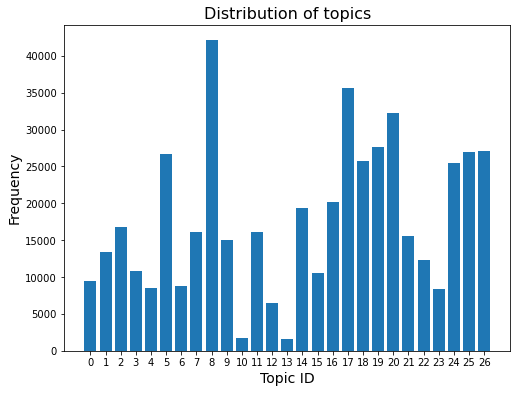

In [ ]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()